# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

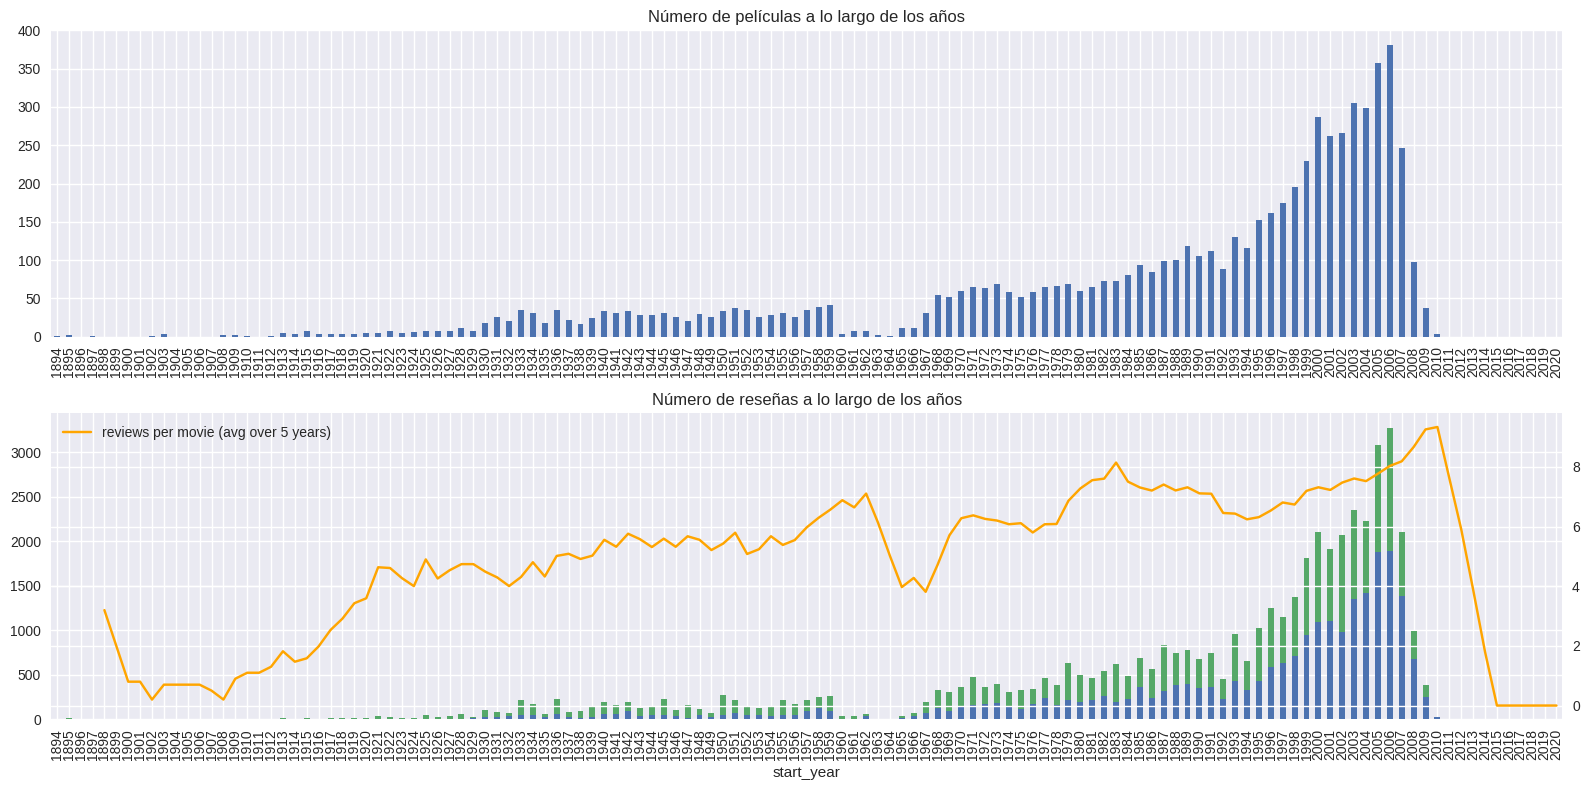

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

En la primera grafica se observar que a partir del 1968 el numero peliculas ha aumento considerablemente y el segundo grafico el numero de reseñas osila en 2200 y 3000 por año

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

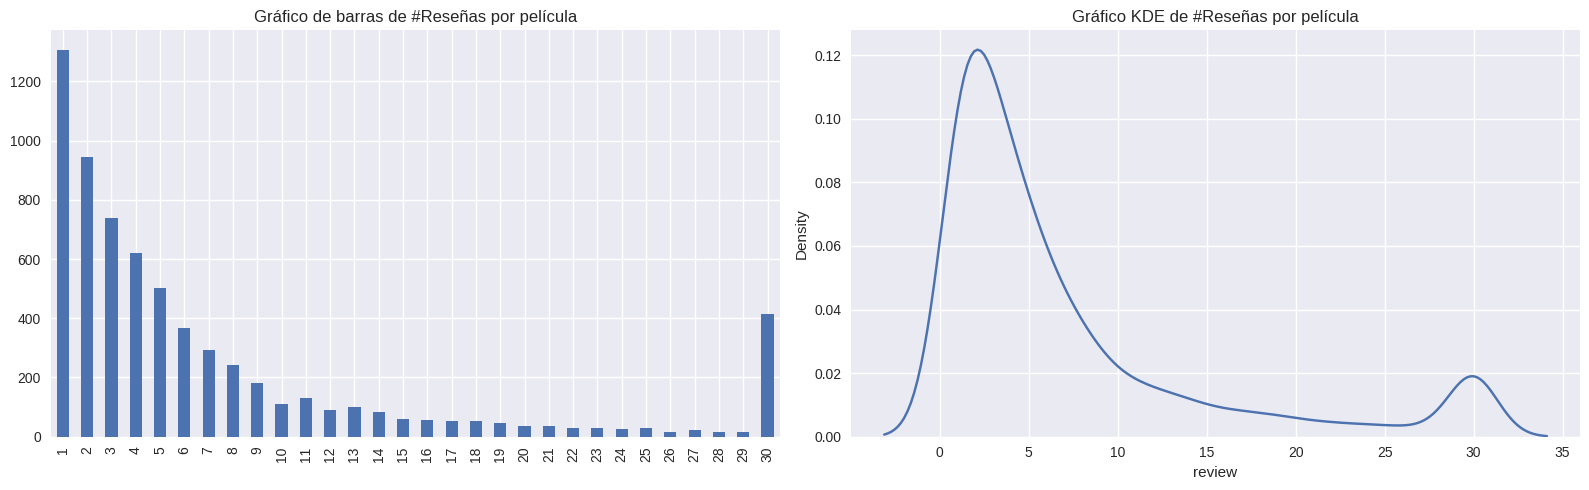

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

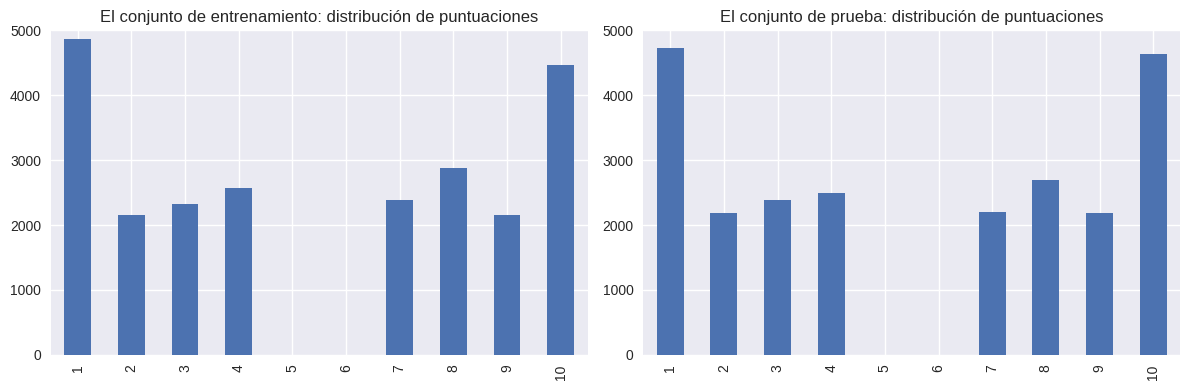

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

En general, tanto el grupo de entrenamiento como de prueba tienen distribuciones de puntuanciones similares.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


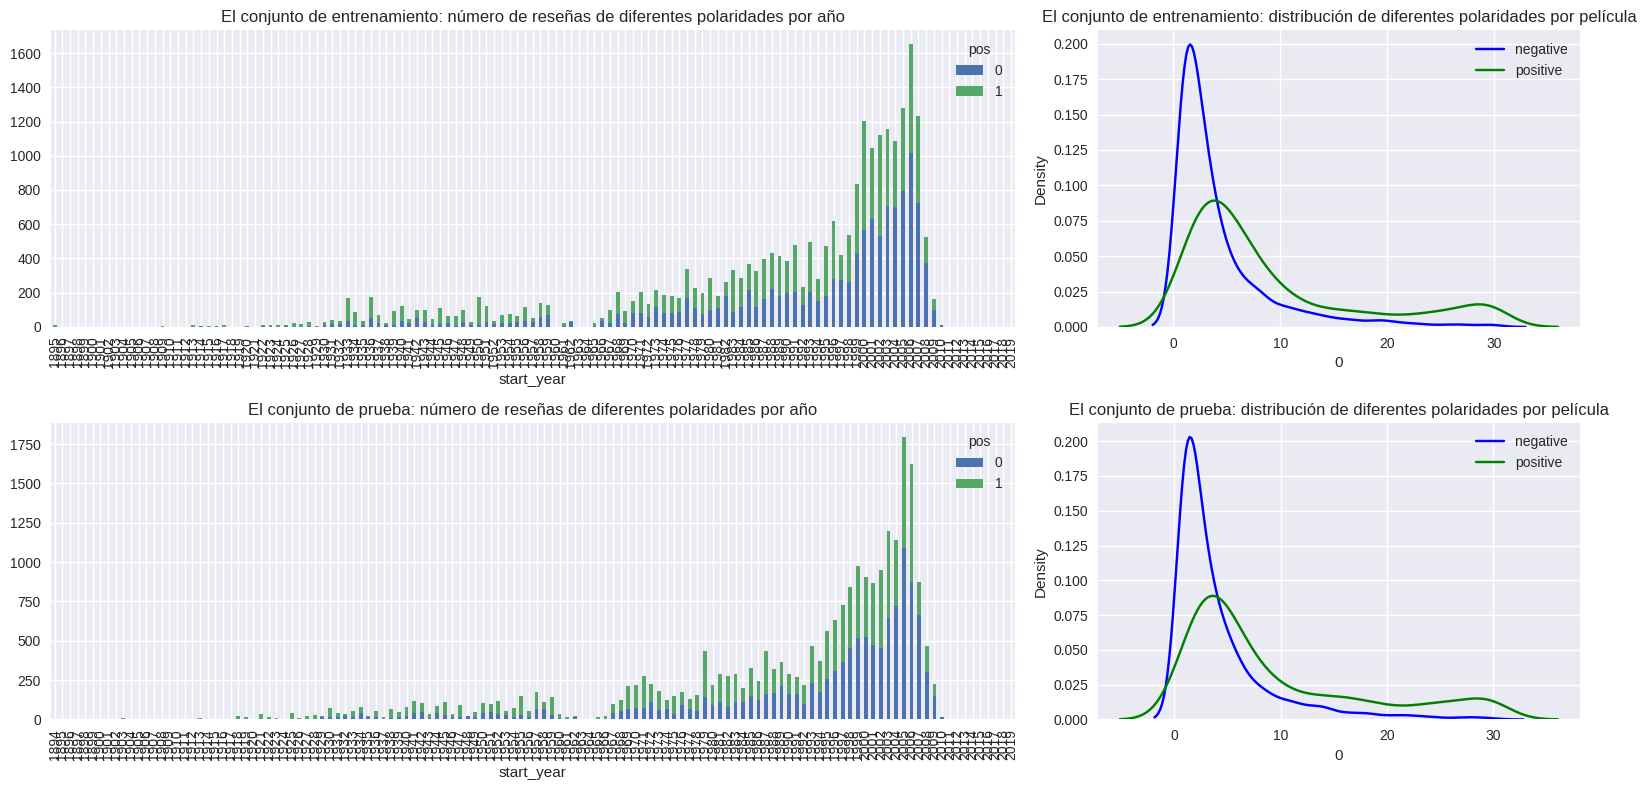

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

En general tiene la misma distribucion tanto el conjunto de entrenamiento y el de prueba

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [11]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return df_eval_stats['test']

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [12]:
import re

def clear_text(text):     
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text = text.split()
    text = " ".join(text)
    text = text.lower()
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)
df_reviews[['review','review_norm']]

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sing...
4,I'm totally agree with GarryJohal from Singapo...,i'm totally agree with garryjohal from singapo...
...,...,...
47326,This is another of my favorite Columbos. It sp...,this is another of my favorite columbos it spo...
47327,Talk about being boring! I got this expecting ...,talk about being boring i got this expecting a...
47328,"I never thought I'd say this about a biopic, b...",i never thought i'd say this about a biopic bu...
47329,Spirit and Chaos is an artistic biopic of Miya...,spirit and chaos is an artistic biopic of miya...


## División entrenamiento / prueba

El conjunto de datos ya especifica que datos deben ser usados para entrenamiento y prueba gracias a la columna ds_part.Por esto, creamos nuestros grupos de entrenamiento y prueba y los guardamos en df_reviews_train y df_reviews_test. Finalmente, separamos los objetivos (target) y caracteristicas (features) para cada caso.

In [13]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

#Caracteristicas y objetivos de entrenamiento
train_features=df_reviews_train['review_norm']
train_target = df_reviews_train['pos']

#Caracteristicas y objetivos de prueba
test_features=df_reviews_test['review_norm']
test_target = df_reviews_test['pos']

## Trabajar con modelos

### Modelo 0 - Constante

In [14]:
from sklearn.dummy import DummyClassifier

In [15]:
model_1=DummyClassifier()
model_1.fit(train_features, train_target)

DummyClassifier()

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


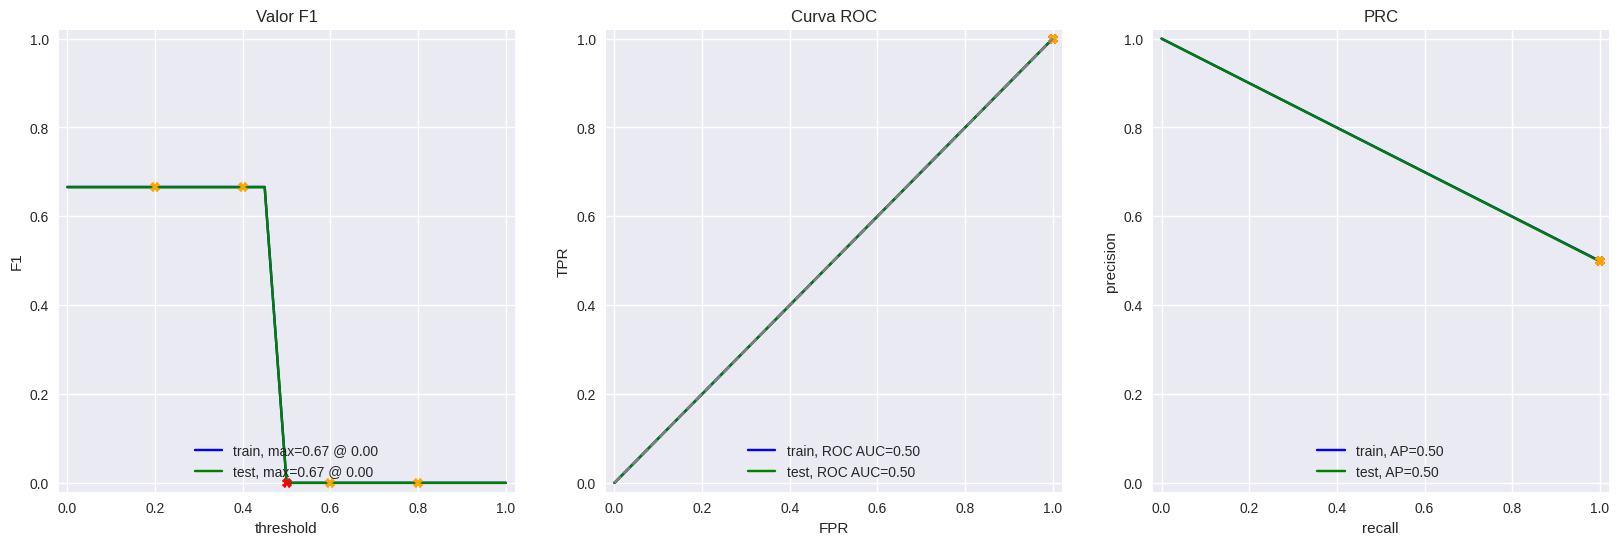

In [16]:
precision_1,f1_1,aps_1,roc_1=evaluate_model(model_1, train_features, train_target, test_features, test_target)

La precisión de este modelo es de un 50% y el desempeño de este modelo es muy malo con un valor F1 igual a cero.

### Modelo 1 - NLTK, TF-IDF y LR

Para este modelo, lematizaremos las reviews usando la libreria NLTK (Natural Language Toolkit), para esto, crearé una función llamada text_preprocessing_2.

Una vez lematizadas las reviews, ponderaré la importancia de cada palabras calculando el TF-IDF (frecuencia de término - frecuencia inversa de documento) el cual transforma todas las palabras del dataset en un vector y asigna valores de relavancia para cada una.

Para aplicar esta transformación usaré TfidfVectorizer de sklearn. Para una mejor vectorización, a TfidfVectorizer le pasaré como atributo las stop_words asociadas al inglés, las cuales no son mas que palabras vacías para inglés ("a", "the","in", "for", etc.) y que serán excluidas de la vectorización.

Finalmente entrenaremos usando un modelo de Regresión Logistica de sklearn y evaluaremos el desempeño usando la función evaluate_model creada anteriormente.

Nota1: Lematizar es reducir una palabra a su forma base o raíz, conocida como "lema".
Nota2: Las stop_words ya estan definidas por la biblioteca NLTK y se llaman usando nltk_stopwords.

In [17]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [18]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer  = WordNetLemmatizer() 

def text_preprocessing_2(text):
    
    tokens = word_tokenize(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    return ' '.join(tokens)

In [19]:
#Lematizar todos el dataframe tarda unos minutos..
#spaCy tarda mas que NLTK
train_features_lemma=train_features.apply(text_preprocessing_2)
test_features_lemma=test_features.apply(text_preprocessing_2)

In [20]:
#Junto las caracteristicas de entrenamiento y prueba para que tenga una matriz TF-IDF equivalente
corpus = pd.concat([train_features_lemma,test_features_lemma])

#Defino las palabras redundantes correspondientes al ingles
stop_words = set(stopwords.words('english'))
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)

#Aplico la transformación TF-IDF
tf_idf = tfidf_vectorizer_2.fit_transform(corpus)
print('El tamaño de la matriz TF-IDF:', tf_idf.shape)

El tamaño de la matriz TF-IDF: (47331, 97026)


In [21]:
#Separamos los target y las caracteristicas (TF-IDF)
train_features_tf_idf =tf_idf[0:len(train_features)]
test_features_tf_idf =tf_idf[len(train_features):len(train_features)+len(test_features)]

#Definimos nuestro modelo (Regresion Logistica)
model_2 = LogisticRegression()
#Entrenamos
model_2.fit(train_features_tf_idf,train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


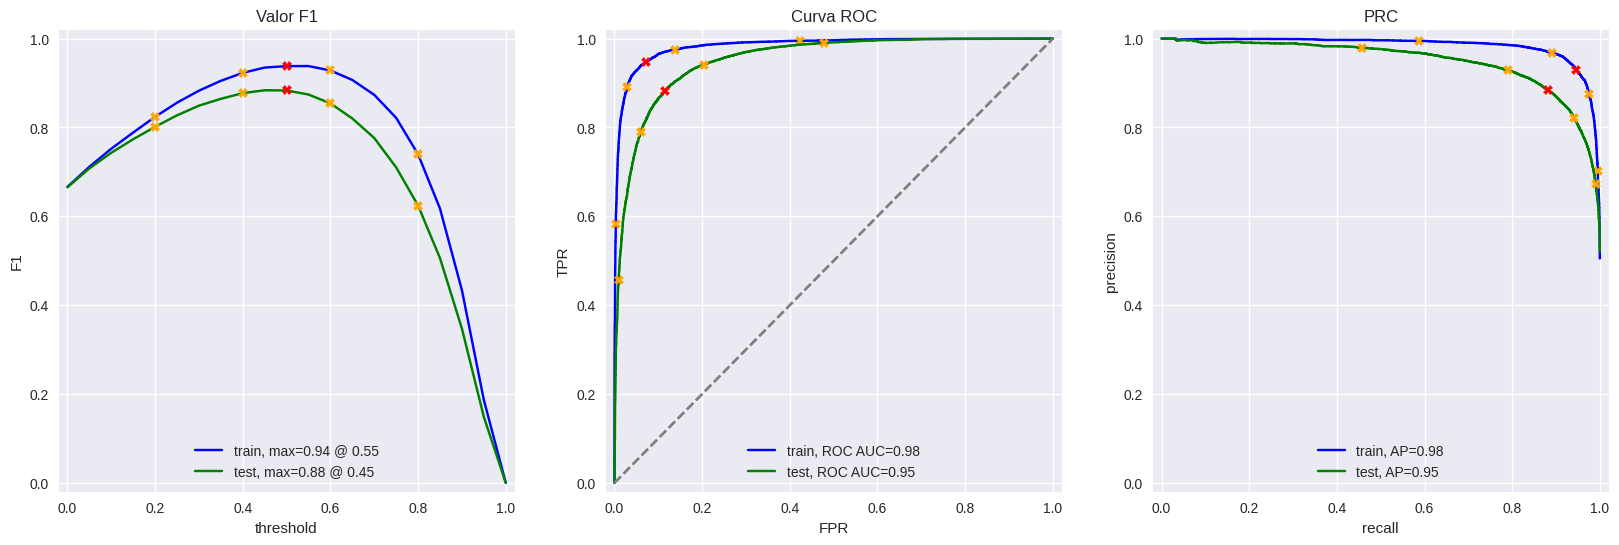

In [22]:
precision_2,f1_2,aps_2,roc_2=evaluate_model(model_2, train_features_tf_idf, train_target, test_features_tf_idf, test_target)

El desempeño de este modelo es bastante bueno, obteniendo una precisión de un 88% y un valor F1 de 0.88 para los datos de prueba. Observamos tambien que este modelo muestra un leve sobreajuste (overfitting) dado que el probarlo con los datos de entrenamiento tiene un desempeño mayor a los nuevos datos de prueba.

Este modelo ya cumple con lo requerido (F1>0.85), sin embargo, evaluaremos el comportamiento de otros modelos a continuación.

### Modelo 3 - spaCy, TF-IDF y LR

Para este modelo, esta vez lematizaremos las reviews usando la libreria spaCy, para esto, crearé una función llamada text_preprocessing_3.

Una vez lematizadas las reviews, ponderaré la importancia de cada palabras calculando el TF-IDF (frecuencia de término - frecuencia inversa de documento) el cual transforma todas las palabras del dataset en un vector y asigna valores de relavancia para cada una.

Para aplicar esta transformación usaré TfidfVectorizer de sklearn. Para una mejor vectorización, a TfidfVectorizer le pasaré como atributo las stop_words asociadas al inglés, las cuales no son mas que palabras vacías para inglés ("a", "the","in", "for", etc.) y que serán excluidas de la vectorización.

Finalmente entrenaremos usando un modelo de Regresión Logistica de sklearn y evaluaremos el desempeño de este modelo usando la función evaluate_model creada anteriormente.

Nota1: Lematizar es reducir una palabra a su forma base o raíz, conocida como "lema".
Nota2: Las stop_words ya estan definidas por la biblioteca NLTK y se llaman usando nltk_stopwords.

In [23]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [24]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [25]:
#Lematizar todos el dataframe tarda unos minutos..
#spaCy tarda mas que NLTK
train_features_lemma=train_features.apply(text_preprocessing_3)
test_features_lemma=test_features.apply(text_preprocessing_3)

In [26]:
#Junto las caracteristicas de entrenamiento y prueba para que tenga una matriz TF-IDF equivalente
corpus = pd.concat([train_features_lemma,test_features_lemma])

#Defino las palabras redundantes correspondientes al ingles
stop_words = set(stopwords.words('english'))
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)

#Aplico la transformación TF-IDF
tf_idf = tfidf_vectorizer_3.fit_transform(corpus)
print('El tamaño de la matriz TF-IDF:', tf_idf.shape)

El tamaño de la matriz TF-IDF: (47331, 82131)


In [27]:
#Separamos los target y las caracteristicas (TF-IDF)
train_features_tf_idf =tf_idf[0:len(train_features)]
test_features_tf_idf =tf_idf[len(train_features):len(train_features)+len(test_features)]

#Definimos nuestro modelo (Regresion Logistica)
model_3 = LogisticRegression()

#Entrenamos
model_3.fit(train_features_tf_idf,train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


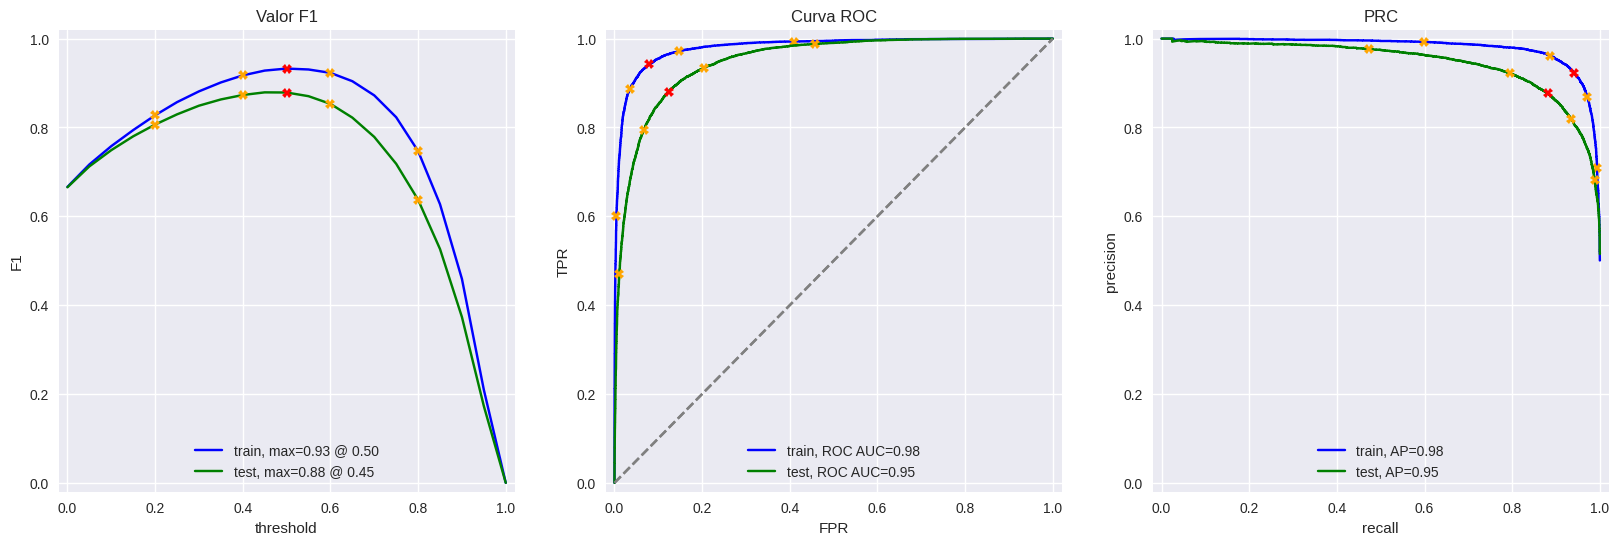

In [28]:
precision_3,f1_3,aps_3,roc_3=evaluate_model(model_3, train_features_tf_idf, train_target, test_features_tf_idf, test_target)

El desempeño de este modelo es prácticamente identico al modelo 2, obteniendo una precisión de un 88% y un valor F1 de 0.88 para los datos de prueba. Observamos tambien que este modelo muestra un leve sobreajuste (overfitting) el cual es menor que el sobrejuste del modelo 2.

Este modelo ya cumple con lo requerido (F1>0.85), sin embargo, evaluaremos el comportamiento de otros modelos.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [29]:
from lightgbm import LGBMClassifier

In [30]:
#Definimos el modelo
model_4 = LGBMClassifier()

#Entrenamos
model_4.fit(train_features_tf_idf,train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


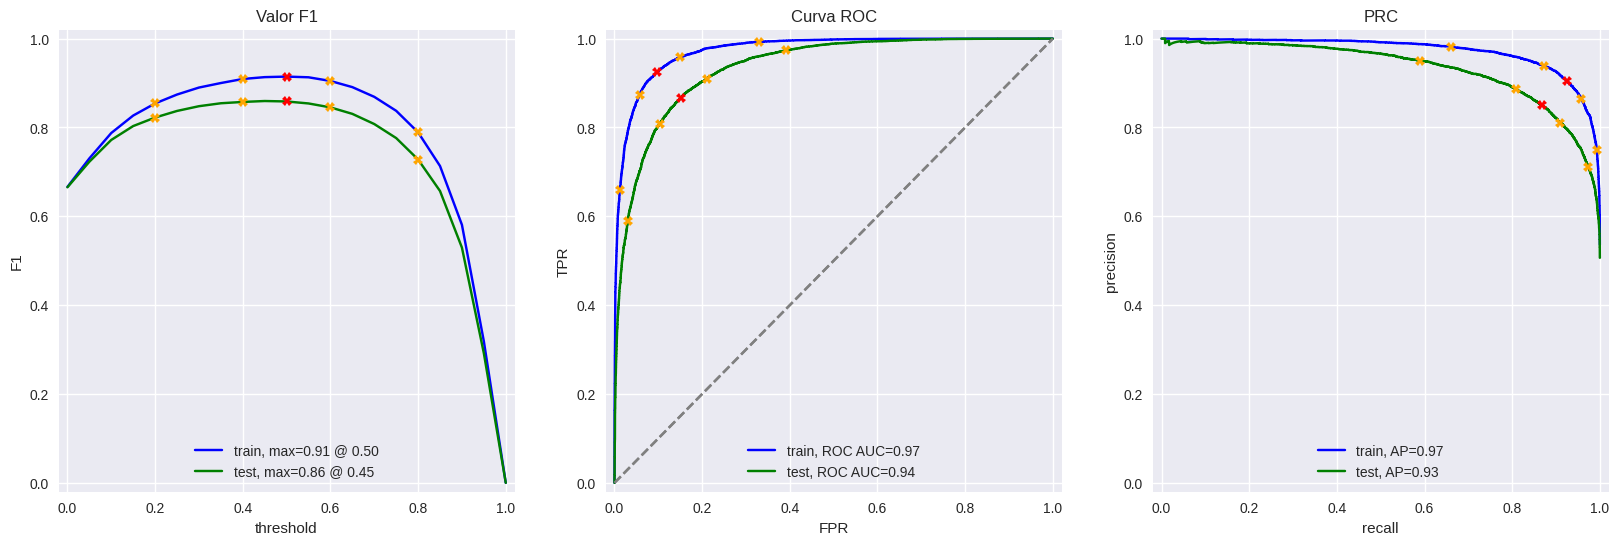

In [31]:
precision_4,f1_4,aps_4,roc_4=evaluate_model(model_4, train_features_tf_idf, train_target, test_features_tf_idf, test_target)

El desempeño de este modelo es bastante bueno, pero inferior a los modelos 2 y 3, obteniendo una precisión de un 86% y un valor F1 de 0.86 para los datos de prueba. Observamos tambien que este modelo muestra un leve sobreajuste (overfitting) el cual es menor que el mostrado por los modelos 2 y 3

Este modelo ya cumple con lo requerido (F1>0.85), sin embargo, evaluaremos el comportamiento de un último modelo.

## Mis reseñas

En este punto, probaré el desempeño de los modelos anteriores usando reseñas aleatorias en inglés (dado que los modelos se entrenaron en inglés) y evaluaremos el desempeño de estos con mi "subjetivo" criterio humano.

In [32]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Modelo 2

In [33]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn't expect the reboot to be so good writers really cared about the source material
0.46:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.83:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3

In [34]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.28:  i didn't expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 4

In [35]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.53:  i did not simply like it not my kind of movie
0.41:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.36:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.70:  i didn't expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.26:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.81:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusiones

In [36]:
resumen = {
    'Modelo': ['Modelo Dummy', 'Modelo 2', 'Modelo 3','Modelo 4'],    
    'Precisión':[precision_1,precision_2,precision_3,precision_4],
    'F1':[f1_1,f1_2,f1_3,f1_4],
    'APS':[aps_1,aps_2,aps_3,aps_4],
    'ROC AUC':[roc_1,roc_2,roc_3,roc_4]
}
#Utilizo round para aproximar a un solo digito
resumen = pd.DataFrame(resumen).round(2)
resumen

,Modelo,Precisión,F1,APS,ROC AUC
0,Modelo Dummy,0.50,0.00,0.50,0.50
1,Modelo 2,0.88,0.88,0.95,0.95
2,Modelo 3,0.88,0.88,0.95,0.95
3,Modelo 4,0.86,0.86,0.93,0.94


Los modelos 2 y 3 (utilizando NLTK o spaCy junto con TF-IDF y Regresión Lineal) parecen ser los más consistentes y efectivos. El modelo con LGBMClassifier también están haciendo un buen trabajo, pero están un poco por debajo de los otros.

Teniendo en cuenta que los modelos 2 y 3 son los que mejores métricas presentan, son los ideales para esta tarea de clasificación, tanto por sus metricas como por su simplicidad en comparación con el resto de modelos.

# Comentario general del revisor 

<div class="alert alert-block alert-success"> 
<b>Comentario del revisor</b> <a class="tocSkip"></a><br> 
    
¡Felicidades David! Tu proyecto está **aprobado**. Has demostrado un excelente manejo de los datos, análisis exploratorio, y creación de modelos predictivos. A continuación, destaco los puntos positivos y algunas áreas interesantes para seguir investigando:

Puntos Positivos:
- **Procesamiento de datos:** El manejo de los datos es muy sólido, incluyendo técnicas de normalización, limpieza y transformación avanzadas como TF-IDF y lematización.
- **Comparación de modelos:** La evaluación detallada y la comparación entre modelos muestran una clara comprensión de las métricas clave y su relevancia en la selección de modelos.
- **Justificación de resultados:** Las conclusiones están bien argumentadas, con un análisis cuidadoso de los puntos fuertes y débiles de cada enfoque.
- **Estructura y claridad:** El proyecto está bien organizado, lo que facilita su comprensión y replicación.

Áreas para Seguir Investigando:
- **Optimización de hiperparámetros:** Experimentar con técnicas como GridSearchCV o RandomizedSearchCV para mejorar aún más el rendimiento de los modelos.
- **Modelos más avanzados:** Explorar redes neuronales y transformers como BERT podría llevar la clasificación de reseñas a un nivel superior.
- **Visualización de métricas:** Complementar las métricas con gráficos más avanzados (e.g., curvas de validación o de aprendizaje) para una comprensión más profunda del comportamiento del modelo.
- **Análisis de interpretabilidad:** Implementar herramientas como SHAP o LIME para analizar las decisiones de los modelos y obtener insights adicionales sobre las palabras clave que influyen en las predicciones.

¡Sigue así, estás haciendo un gran trabajo! 💪🚀😊 
</div> 